# Long Call Option

### I. Strategy Overview

#### Payoff

![](long_call.jpg)

#### Features:
* Long Delta: option value increases as the underlying price goes up
* Long volatility: option value increases as the implied volatility hikes
* Short Theta: option value decreases as time decays

### II. Strategy Setup

In [1]:
import sys  
sys.path.insert(0, 'C:\\Users\\chena\\Desktop\\Trading\\StrategicOptions\\')
import datetime
from mainprg_backtest import OptionBackTesting, BackTestingVisualization

####  1. Input symbol of underlying

In [2]:
Ticker = 'MSFT'

#### 2. Specify testing period and find out the expiration dates within

In [3]:
Start_Date = datetime.datetime(2016, 10, 9)
End_Date = datetime.datetime(2017, 10, 31)

expiry = OptionBackTesting(Ticker, [], [], Start_Date, End_Date,  []).set_expiration_calendar()
print(expiry)

                Business Day Day of the Week Year-Month
0  2016-10-28 00:00:00+00:00          Friday    2016-10
1  2016-11-18 00:00:00+00:00          Friday    2016-11
2  2016-12-16 00:00:00+00:00          Friday    2016-12
3  2017-01-20 00:00:00+00:00          Friday    2017-01
4  2017-02-17 00:00:00+00:00          Friday    2017-02
5  2017-03-17 00:00:00+00:00          Friday    2017-03
6  2017-04-28 00:00:00+00:00          Friday    2017-04
7  2017-05-19 00:00:00+00:00          Friday    2017-05
8  2017-06-16 00:00:00+00:00          Friday    2017-06
9  2017-07-21 00:00:00+00:00          Friday    2017-07
10 2017-08-18 00:00:00+00:00          Friday    2017-08
11 2017-09-15 00:00:00+00:00          Friday    2017-09
12 2017-10-20 00:00:00+00:00          Friday    2017-10


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1088: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


#### 3. Select an expiration date

In [4]:
expiration = datetime.datetime(2016, 11, 18)

#### 4. Choose option enter and exit dates

In [5]:
entry_date = datetime.datetime(2016, 10, 10)
exit_date = datetime.datetime(2016, 11, 4)

#### 5. Option Type & Strike Price Selection
* Change the strike price to see how it affects the strategy

In [16]:
option_type = 'C'
strike_price = 55  # At the money

# strike_price = 50  # Deep in the money
# strike_price = 65  # Far out of the money

### III. Visualization
#### 1. Generate options basic data

In [17]:
option_data = OptionBackTesting(Ticker, strike_price, [], entry_date, exit_date, option_type)
option_price, option_return, underlying_price, underlying_return, trading_days, iv, hv = option_data.generate_data()

##### 2. Speficy spot price range and generate payoff chart

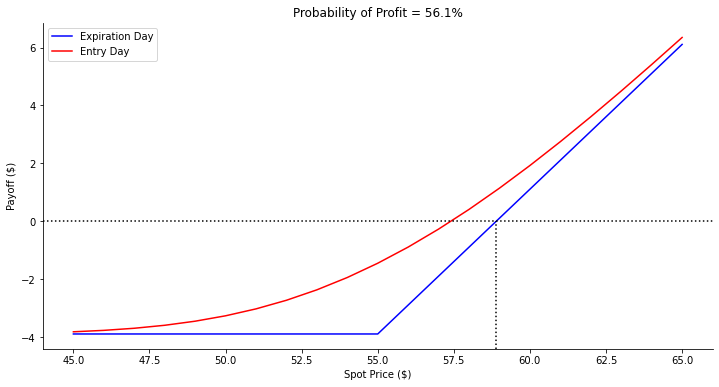

In [18]:
lower_limit = 45 # Modify to customize the lower bound of x-axis
upper_limit = 65 # Modify to customize the upper bound of x-axis

# Generate payoffs
payoff_calc = BackTestingVisualization(trading_days, option_price, underlying_price, option_return, underlying_return, iv, strike_price, expiration, entry_date, exit_date, lower_limit, upper_limit, 'C')
payoff_calc.plot_payoff()

# Probability of profit


#### 3. Price Moves and Returns

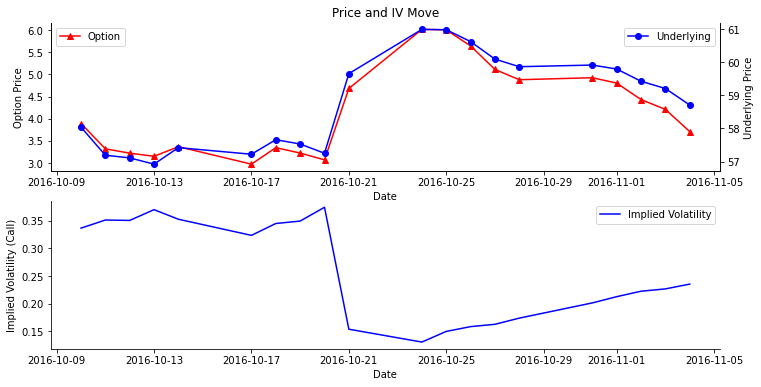

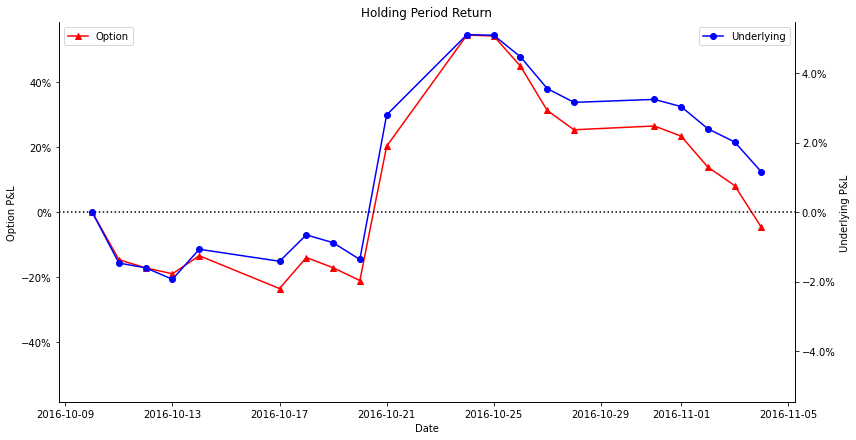

In [19]:
# viz = BackTestingVisualization(trading_days, option_price, underlying_price, option_return, underlying_return, iv,[],[],[],[],[],[])
payoff_calc.plot_price_history()
payoff_calc.plot_option_pnl()

### IV. Trade Journaling

In [20]:
payoff_calc.print_strategy_summary()
payoff_calc.strategy_summary

,Holding Period (Days),Cost Basis,Residual Value,P&L,PnL/Day,ROC,Win
0,25,$389.30,$371.00,$-18.30,$-0.73,-4.7%,False


### V. Recurring Strategy Setup